# Setup

In [13]:
# Basico
import pandas as pd
import numpy as np

# Sistema
import os

# SQL
from sqlalchemy import create_engine

# Sklearn
from sklearn.metrics import mean_squared_error

# Scipy
from scipy.stats import skew
from scipy.stats.mstats import winsorize

# MLFlow
import mlflow
from mlflow.tracking import MlflowClient

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Config
mlflow.set_tracking_uri("file:../models/mlruns")
client = MlflowClient()

# Variaveis de ambiente
host = os.getenv("MYSQL_HOST")
user = os.getenv("MYSQL_USER")
password = os.getenv("MYSQL_PASSWORD")
database = os.getenv("MYSQL_DB")
port = os.getenv("MYSQL_PORT")

EXPERIMENT_ID = "500317620984170799"

In [2]:
# Apps de validação separados na modelagem
val_apps = ['com.app.50760', 'com.app.37962', 'com.app.24391', 'com.app.35851',
            'com.app.91390', 'com.app.50792', 'com.app.62062', 'com.app.88311',
            'com.app.68335', 'com.app.31454', 'com.app.81754', 'com.app.31679',
            'com.app.59849', 'com.app.17441', 'com.app.82896', 'com.app.85231',
            'com.app.37148', 'com.app.68015', 'com.app.80569', 'com.app.72653',
            'com.app.24343', 'com.app.19821', 'com.app.95194', 'com.app.19872',
            'com.app.97802', 'com.app.41189']

# Features e targets
feature_cols = ['target_lag3',
                'daily_reviews',
                'target_lag',
                'maureal',
                'daureal_maureal',
                'reviews',
                'target_lag7',
                'daureal',
                'dia_semana']

target_cols = ['target','target_d7']

### Funções

In [14]:
# Preenche os valores nulos pela mediana de cada app
def preencher_com_mediana(df, colunas):
    df_temp = df.copy()

    for coluna in colunas:
        df_temp[coluna] = df_temp.groupby('appid')[coluna].transform(lambda x: x.fillna(round(x.dropna().median())))

    return df_temp

# Métrica MedAPE
def medape(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

# Carrega modelo com menor MedAPE
def load_best_model(experiment_id, modelo, target):
    runs = client.search_runs(
        experiment_ids=[experiment_id],
        filter_string=f'params.modelo = "{modelo}" and params.target = "{target}"',
        order_by=["metrics.medape ASC"],
        max_results=1
    )
    best_run = runs[0]
    artifact = "glm_model" if modelo == "glm" else "mixedlm_model"
    model_uri = f"runs:/{best_run.info.run_id}/{artifact}"
    model = mlflow.statsmodels.load_model(model_uri)
    return model, best_run

In [29]:
# Plota diagnósticos de modelo statsmodels (GLM ou MixedLM):
# Resíduos vs valores ajustados (fitted)
# Valores reais vs preditos
# Histograma de resíduos

def plot_model_diagnostics(model, df, target_col):
    # Extrai valores ajustados e resíduos
    fitted = model.fittedvalues
    # Para GLM, resid é resid_response; para MixedLM, resid é resid
    if hasattr(model, 'resid_response'):
        residuals = model.resid_response
    else:
        residuals = model.resid
    
    # Valores observados e preditos
    actual = df[target_col]
    predicted = fitted

    # Resíduos vs Fitted
    plt.figure(figsize=(10,3))
    sns.scatterplot(x=fitted, y=residuals, alpha=0.3)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Fitted values')
    plt.ylabel('Resíduos')
    plt.title(f'Resíduos vs Fitted: {target_col}')
    plt.tight_layout()
    plt.show()

    # Real vs Predito
    plt.figure(figsize=(10,3))
    sns.scatterplot(x=actual, y=predicted, alpha=0.3)
    # linha de identidade
    mn, mx = actual.min(), actual.max()
    plt.plot([mn, mx], [mn, mx], color='red', linestyle='--')
    plt.xlabel('Observado')
    plt.ylabel('Predito')
    plt.title(f'Real vs Predito: {target_col}')
    plt.tight_layout()
    plt.show()

    # Histograma de Resíduos
    plt.figure(figsize=(10,3))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel('Resíduos')
    plt.title(f'Histograma de Resíduos: {target_col}')
    plt.tight_layout()
    plt.show()
    

### Carrega SQL

In [17]:
# Cria a engine
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')

# Seleciona tabelas essenciais
keep_tables = ['daumau','ratings_reviews']

# Leitura de dados
raw_data = {}

for table in keep_tables:
    print(f"Lendo tabela: {table}")
    raw_data[table] = pd.read_sql(f"SELECT * FROM {table} LIMIT 100000;", con=engine)
    raw_data[table].columns = [c.lower() for c in raw_data[table].columns]

    raw_data[table] = raw_data[table][raw_data[table]['appid'].isin(val_apps)].reset_index(drop=True)

Lendo tabela: daumau
Lendo tabela: ratings_reviews


### Carrega Modelos

In [18]:
# Carrega modelos e best_runs
glm_target, run_glm_target = load_best_model(EXPERIMENT_ID, "glm", "target")
glm_target_d7, run_glm_target_d7 = load_best_model(EXPERIMENT_ID, "glm", "target_d7")
lme_target,run_lme_target = load_best_model(EXPERIMENT_ID, "lme", "target")
lme_target_d7, run_lme_target_d7 = load_best_model(EXPERIMENT_ID, "lme", "target_d7")

# Dicionario de modelos
models = {
    "glm_target": glm_target,
    "glm_target_d7": glm_target_d7,
    "lme_target": lme_target,
    "lme_target_d7": lme_target_d7
}


# Tratamento dos dados de validação
- Join, NaNs, Datas, Outliers, Scaling

In [19]:
# Merge
df_validation = raw_data['daumau'].merge(raw_data['ratings_reviews'], on=['date','appid'], how='outer')

# Preenche NaNs
colunas_numericas = ['daureal','maureal','reviews','daily_reviews']

df_validation = preencher_com_mediana(df_validation, colunas_numericas)
df_validation.drop('category',axis=1,inplace=True)

# Tira datas erradas
df_validation["date"] = pd.to_datetime(df_validation["date"]).dt.floor("D")
df_validation = df_validation[((df_validation["date"] >= pd.to_datetime("2024-01-01")) 
                                & (df_validation["date"] <= pd.to_datetime("2024-12-31")))]

# Criação de colunas
df_validation['target'] = df_validation.groupby('appid')['daureal'].shift(-1)
df_validation['target_d7'] = df_validation.groupby('appid')['daureal'].transform(lambda x: x.shift(-1).rolling(window=7, min_periods=1).sum())

df_validation[f'target_lag'] = df_validation.groupby('appid')['target'].shift()
df_validation[f'target_lag3'] = df_validation.groupby('appid')['target'].shift(periods=3)
df_validation[f'target_lag7'] = df_validation.groupby('appid')['target'].shift(periods=7)
df_validation['daureal_maureal'] = df_validation['daureal'] / df_validation['maureal']
df_validation['dia_semana'] = df_validation['date'].dt.day_name()

# Filtra colunas
df_validation = df_validation[["appid"] + feature_cols + target_cols]

df_validation.dropna(inplace=True)
df_validation.replace([np.inf, -np.inf], 0, inplace=True)
df_validation.reset_index(drop=True,inplace=True)

# Outliers e Scaling
skew_to_limit = {
    0.5: 0.01,
    1.0: 0.03,
    2.0: 0.05,
    float('inf'): 0.10
}

# Normaliza por log se existirem só valores positivos, do contrário usa winsorize dinâmico
normalize_cols = [x for x in feature_cols if x!='dia_semana'] + ['target','target_d7']
for col in np.sort(normalize_cols):
    if df_validation[col].min()>0:
        df_validation[col] = np.log1p(df_validation[col])
    else:
        sk = abs(skew(df_validation[col].dropna().astype(float)))
        limit = next(v for k, v in skew_to_limit.items() if sk <= k)
        df_validation[col] = winsorize(df_validation[col].astype(float), limits=[limit, limit])


In [20]:
df_validation.head()

,appid,target_lag3,daily_reviews,target_lag,maureal,daureal_maureal,reviews,target_lag7,daureal,dia_semana,target,target_d7
0,com.app.80569,9.524202,5.0,9.561138,12.043024,0.080270,9.564302,9.568854,9.561138,Monday,9.548169,11.478562
1,com.app.80569,9.445966,7.0,9.548169,12.044594,0.079156,9.564653,9.560645,9.548169,Tuesday,9.507923,11.470988
2,com.app.59849,10.398367,0.0,10.386346,13.410836,0.047438,12.835891,10.533429,10.386346,Monday,10.380001,12.409181
3,com.app.59849,10.337346,0.0,10.380001,13.370293,0.049048,12.835705,10.739761,10.380001,Tuesday,10.367159,12.348804
4,com.app.31454,7.822044,0.0,8.662505,10.848852,0.106438,6.543912,8.470940,8.662505,Monday,8.616133,10.326858


# Validação

In [21]:
# Formata colunas do modelo
num_cols = [c for c in feature_cols if c != 'dia_semana']

df_validation[num_cols + target_cols] = df_validation[num_cols + target_cols].astype(np.float64)
df_validation['dia_semana'] = df_validation['dia_semana'].astype('category')
df_validation['appid'] = df_validation['appid'].astype('category')

### LME
- Validação do modelo LME

In [22]:
# Testa os 2 targets: d+1 e d+7 soma movel
for c_target in ['target','target_d7']:
    x_test = df_validation.drop(['target','target_d7'],axis=1)
    y_test = df_validation[c_target]
    predicted = models[f"lme_{c_target}"].predict(x_test)

    predicted = np.expm1(predicted)
    y_test = np.expm1(y_test)

    rmse_lme = np.sqrt(mean_squared_error(y_test, predicted))
    medape_lme = medape(y_test, predicted)

    print(f"RMSE {c_target}: {rmse_lme:.2f}")
    print(f"MedAPE {c_target}: {medape_lme:.2f}%\n")

RMSE target: 333411.80
MedAPE target: 11.22%

RMSE target_d7: 1244893.18
MedAPE target_d7: 6.43%



### GLM
- Validação do modelo GLM

In [24]:
# Testa os 2 targets: d+1 e d+7 soma movel
for c_target in ['target','target_d7']:
    x_test = df_validation.drop(['target','target_d7'],axis=1)
    y_test = df_validation[c_target]
    predicted = models[f"glm_{c_target}"].predict(x_test)

    predicted = np.expm1(predicted)
    y_test = np.expm1(y_test)

    rmse_lme = np.sqrt(mean_squared_error(y_test, predicted))
    medape_lme = medape(y_test, predicted)

    print(f"RMSE {c_target}: {rmse_lme:.2f}")
    print(f"MedAPE {c_target}: {medape_lme:.2f}%\n")

RMSE target: 139689.34
MedAPE target: 6.55%

RMSE target_d7: 1415330.90
MedAPE target_d7: 4.75%



# Visualização
- Resíduos vs Fitted
- Real vs Predito
- Histograma de Resíduos

### LME - Target

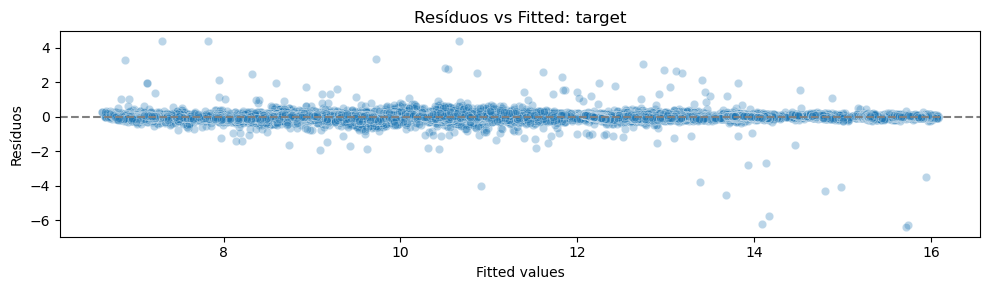

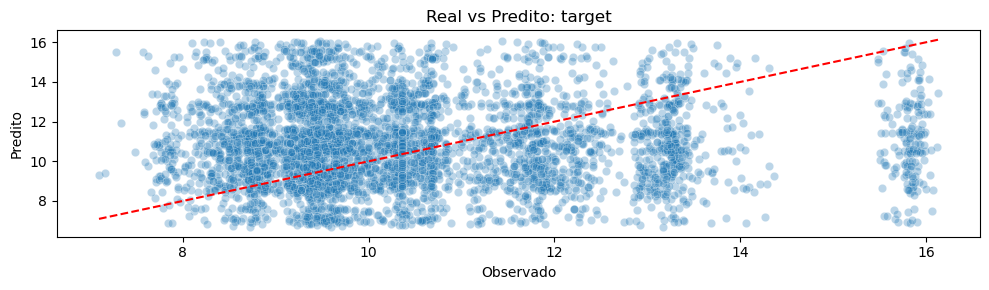

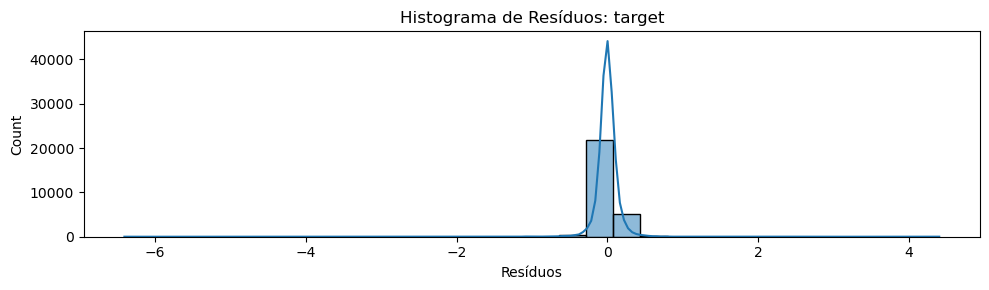

In [30]:
plot_model_diagnostics(models['lme_target'], df_validation, target_col='target')

### LME - Target d+7 soma

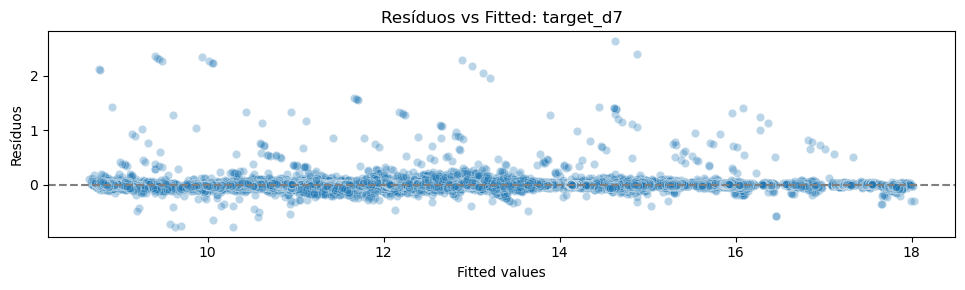

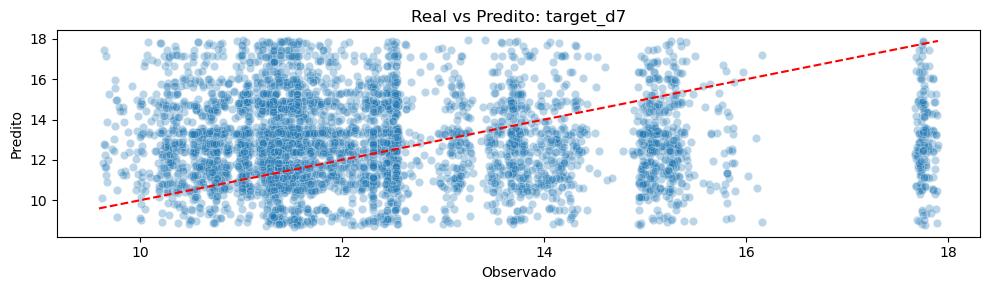

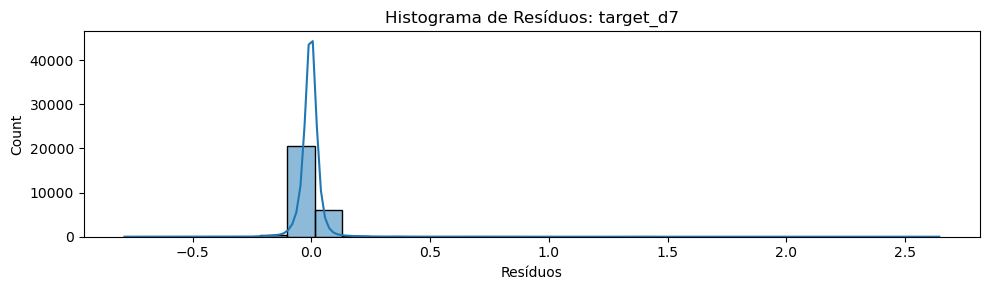

In [31]:
plot_model_diagnostics(models['lme_target_d7'], df_validation, target_col='target_d7')

### GLM - Target

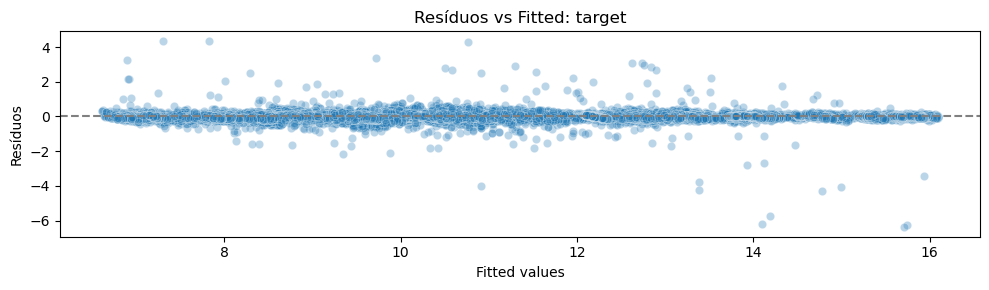

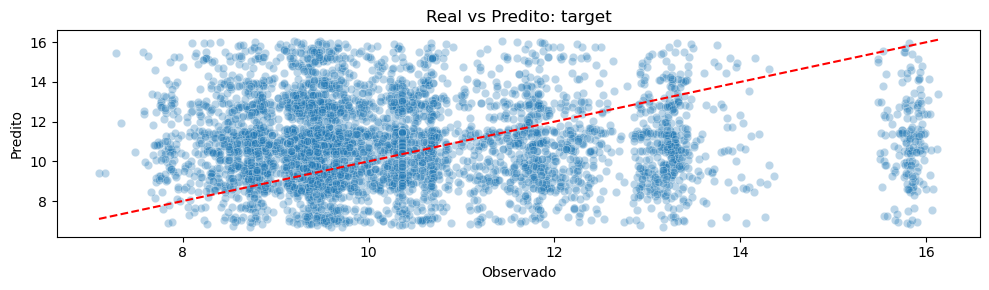

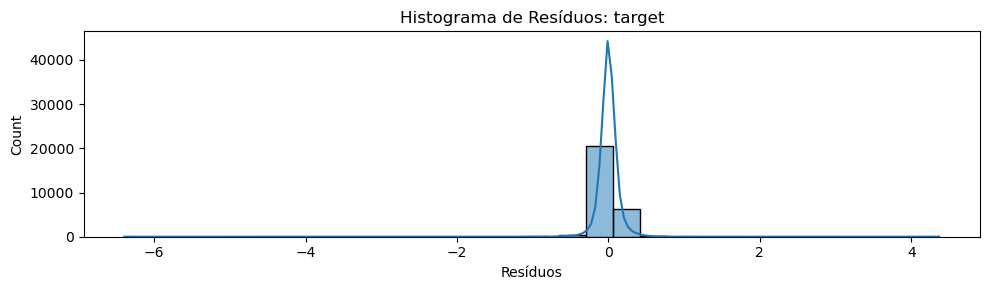

In [32]:
plot_model_diagnostics(models['glm_target'], df_validation, target_col='target')

### GLM - Target d+7 soma

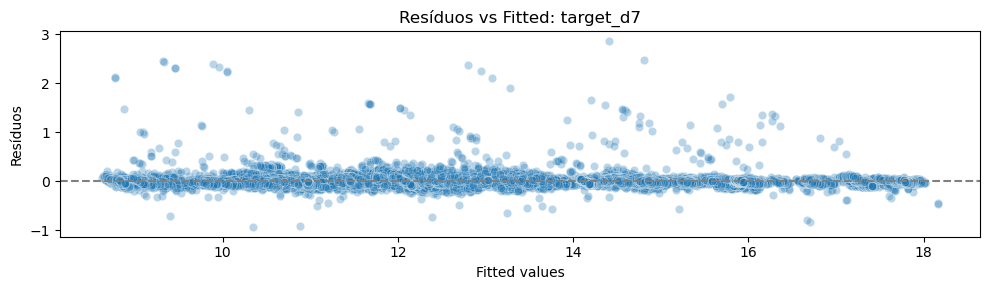

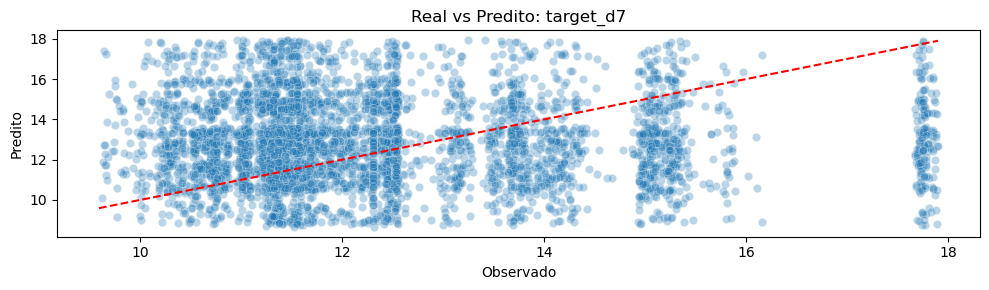

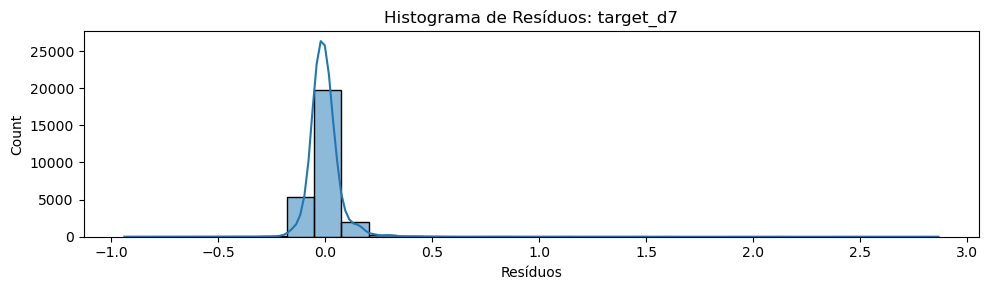

In [33]:
plot_model_diagnostics(models['glm_target_d7'], df_validation, target_col='target_d7')
